# Section 4

## Preliminaries

### Essential Reading
Before attempting this section you should read "[_On the Estimation of Confidence Intervals for Binomial Population Proportions in Astronomy: The Simplicity and Superiority of the Bayesian Approach_](https://arxiv.org/pdf/1012.0566.pdf)" by Ewan Cameron.

## Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results.

### Exercise 1 (AST4031 & AST5031):

A common problem that astronomers often encounter is how to assign appropriate error bars to measured frequencies. In this exercise you will demonstrate how the most commonly used approach - assuming Gaussian errors - can have serious shortcomings under certain circumstances. Subsequently, you will demonstrate that an alternative prescription provides better estimates for the errors.

1. Write code to generate random variates consistent with a Binomial probability mass function. You may use `numpy` or `scipy` routines for this task.
2. Write code to simulate a large number of random realizations of [Bernoulli processes](https://en.wikipedia.org/wiki/Bernoulli_process) for different numbers of Bernoulli trials $N$ and success probabilities $p$.
3. For each random realization, compute an estimator $\hat{p}$ for the true value of $p$.
4. For each random realization, compute confidence intervals on the estimated $\hat{p}$ using two of the methods outlined in [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf)
    1. Using the "Normal approximation".
    2. Using Binomial Confidence Intervals.
5. For each type of confidence interval, write code to compute the _coverage_ as the fraction of realizations for which the confidence interval contains the true value of $p$.
6. Show how the coverage changes as a function $N$ and $p$.

In [1]:
import numpy as np
import numpy.random as nprandom
import matplotlib
import matplotlib.pyplot as mplplot

import scipy.stats.distributions as spdists

import collections

%matplotlib inline

### Solution
#### Part 1
Since we may use `numpy` routines, this task is trivial. It's not essential, but I'll wrap the `numpy.random` routine in a function to make the parameter names slightly more explicit.

In [2]:
def binomialVariates(numTrials, successProb, numVariates):
    return nprandom.binomial(n=numTrials, p=successProb, size=numVariates)

Let's quickly generate and plot some variates to validate our code.

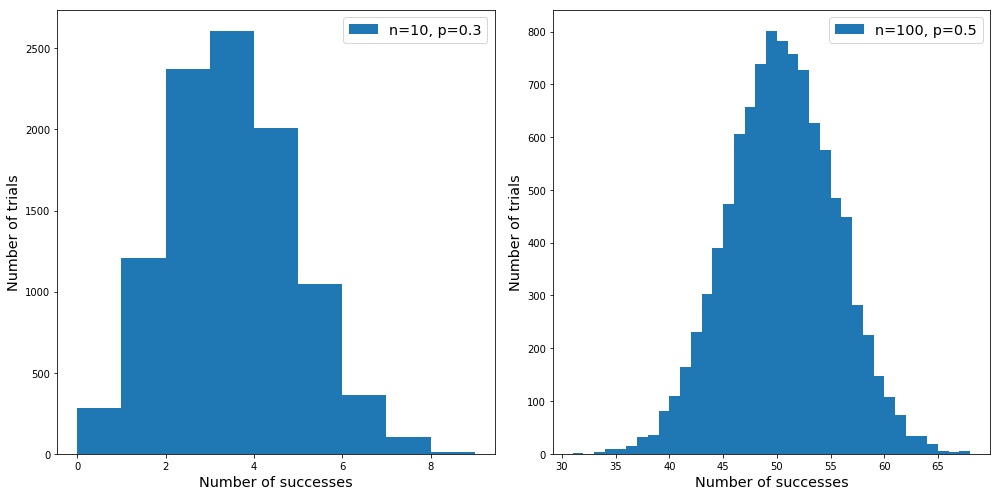

In [3]:
binomialTestFigure, binomialTestAxes = mplplot.subplots(ncols=2, nrows=1, figsize=(14,7))

numVariates=10000

for binomialTestAxis, numTrials, successProb in zip(binomialTestAxes, [10, 100], [0.3, 0.5]):
    successCounts = binomialVariates(numTrials, successProb, numVariates)
    binomialTestAxis.hist(successCounts, 
                          bins=np.amax(successCounts) - np.amin(successCounts), 
                          label='n={}, p={}'.format(numTrials, successProb))

    binomialTestAxis.set_xlabel('Number of successes', fontsize='x-large')
    binomialTestAxis.set_ylabel('Number of trials', fontsize='x-large')
    binomialTestAxis.legend(fontsize='x-large')

mplplot.tight_layout()

Looks good to me!

#### Part 2

The simplest way to implement the code we need is to repeatedly invoke the function we defined in _Part 1_ with different input arguments. We'll define a "wrapper" function that accepts ranges of $N$ and $p$ as its arguments and then produces a sample of Binomial variates for all permuations $(N, p)$ that can be formed from the range elements.

We'll store the results as the _values_ in a [`collections.OrderedDict`](https://docs.python.org/3/library/collections.html#collections.OrderedDict) data structure with _keys_ corresponding to the $(N, p)$ permutations.

While normal python `dict` data structures to not guarantee the ordering of their elements, an `OrderedDict` does. This fact will allow us to maintain generate monotonic two-dimensional plotting ranges from the `OrderedDict` keys.

In [4]:
def bernoulliProcesses(numTrialRange, successProbRange, numVariates):
    return collections.OrderedDict({(numTrials, successProb): binomialVariates(numTrials, successProb, numVariates) for successProb in successProbRange for numTrials in numTrialRange})

To choose reasonable ranges of $N$ and $p$ to simulate, we'll anticipate the later parts of this excercise that ask us to
> Show how the coverage changes as a function $N$ and $p$.

and reference _Section 3_ (_Figure 2_) of the [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf), which specifies
> a range of population proportions and sample sizes ($0.025\leq p\leq0.975$ and $1􏰃\leq N\leq 100$)

In [5]:
numTrialRange = np.arange(1, 100).astype(int)
successProbRange = np.arange(0.025, 0.975, 0.025)

Furthermore, the [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf) specifies confidence intervals a nominal level 
> a nominal level $c_{n} = 0.683$

For each permutation of $(N, p)$, we'll simulate experiments comprising $10^{5}$ Bernoulli processes. We can use our `bernoulliProcesses` function to run the simulation. 

In [6]:
nominalConfidence = 0.683
numVariates = 10000
experiments = bernoulliProcesses(numTrialRange, successProbRange, numVariates)

#### Part 3
Now that we have our experimental data, we can generate maximum likelihood estimators $\hat{p}$ for the true population success probablilites. The [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf) tells us that if $k$ successes are observed within $n$ trials, then
$$
\hat{p} = \frac{k}{n}
$$
Estimators for the failure probabilities $\hat{q}$ are simply the complements of the $\hat{p}$ values for each experiment.
$$
\hat{q} = 1 - \hat{p}
$$
We'll unify the results of our experiments into a two-dimensional `numpy` array. Since we ran $Np$ experiments, each yielding $10^{5}$ independent values for $k$, shape of this array will be $Np\times10^{5}$.

In [7]:
successCounts = np.array(list(experiments.values()))
print('Experimental results array has shape:', successCounts.shape)

Experimental results array has shape: (3762, 10000)


We chose to use an `OrderedDict` to store our results. This means that we can extract values for $N$ and $p$ from the keys of our `experiments` data structure and they are guaranteed to be in the same order as the arrays of $k$-values we just extracted.

Note that the `numpy` array that would result from directly converting the keys would be two-dimensional with shape $10^{5}\times 2$. By transposing the array to have shape $2\times 10^{5}$ using the `T` attribute, we can automatically unpack it into two 1-dimensional arrays with length $10^{5}$.

In [8]:
trialCounts, successProbs = np.array(list(experiments.keys())).T
print('The trial count and success probability arrays have lengths {} and {}, respectively.'.format(
    len(trialCounts),
    len(successProbs))
     )

The trial count and success probability arrays have lengths 3762 and 3762, respectively.


Now we're ready to compute our estimators. We can use `numpy`'s [broadcasting functionality](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) to perform and element-wise division of every column of our `successCounts` array by the corresponding element of the `trialCounts` array. The broadcasting behaviour can be confusing to start with, but it is extremely powerful and can increase the efficiency of your code by orders of magnitude!

In [9]:
pEstimators = (successCounts.T/trialCounts).T
qEstimators = np.ones_like(pEstimators) - pEstimators

#### Part 4 A
To compute confidence intervals using the _Normal Approximation_, we'll use the formulae specified in [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf).
$$
\hat{p} - z_{1-\alpha/2}\sqrt{\frac{\hat{p}\hat{q}}{n}} < p < \hat{p} + z_{1-\alpha/2}\sqrt{\frac{\hat{p}\hat{q}}{n}}:\; z_{1-\alpha/2} = 1
$$

In [10]:
normalDeviations = np.sqrt((pEstimators*qEstimators).T/trialCounts).T
normalLowerBounds = pEstimators - normalDeviations
normalUpperBounds = pEstimators + normalDeviations

#### Part 5 A
To compute the coverage fractions, we need to determine how many of the confidence intervals for each ($N,p$) permutation contain the true value of $p$ and divide this by the number of Bernoulli processes in each experiment. Again, we can use `numpy` broadcasting and transposition to increase the readability and efficiency of our code. Using  `numpy` we can perform element-wise Boolean-valued comparisons between arrays. Note that the **logical and** operator for **arrays** is `&` and **not** `and` as it would be for ordinary Python data types.

To help understand how transposition and broadcasting operate, we can print the shapes of the various involved arrays. A rule of thumb is that for broadcasting to work, the sizes of the last dimensions of the arrays being operated on must match. This is why `normalLowerBounds` and `normalUpperBounds` must be transposed before they can be compared with `successProbs`.

To compute the number of intervals that contain the true value for each ($N,p$) we can sum (project) along the zeroth axis of the two dimensional array boolean values indicating containement within the computed interval.

In [11]:
print('Shapes of normalLowerBounds, normalUpperBounds and successProbs are {}, {} and {}, respectively'.format(
    normalLowerBounds.shape, 
    normalUpperBounds.shape, 
    successProbs.shape),
     end='\n\n')
normalContainmentStatuses = ((normalLowerBounds.T < successProbs) & (normalUpperBounds.T > successProbs))
print('Shape of normalContainmentStatuses is', normalContainmentStatuses.shape, end='\n\n')
normalCoverageFractions = np.sum(normalContainmentStatuses, axis=0)/numVariates
print('Shape of normalCoverageFractions is', normalCoverageFractions.shape)

Shapes of normalLowerBounds, normalUpperBounds and successProbs are (3762, 10000), (3762, 10000) and (3762,), respectively

Shape of normalContainmentStatuses is (10000, 3762)

Shape of normalCoverageFractions is (3762,)


#### Part 6 A:
The simplest way to show how the coverage fractions vary as a function of $N$ and $p$ is to replicate the figures from [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf). We'll plot the coverage fractions versus $N$ and $p$ in two dimensions and the mean coverage fraction versus $N$ in one dimension. If we define a function to generate the plots we need, we can re-use it later.

To compute the mean coverage fraction at each $N$ we need to manipulate the shape of our data. The coverage fraction data are stored as a 1-dimensional array. The ordering of the data is such that elements corresponding to the same $N$ are adjacent i.e. 
$$[c_{N_{1}}^{p_{1}}, c_{N_{1}}^{p_{2}},\ldots, c_{N_{1}}^{p_{99}}, c_{N_{2}}^{p_{1}}, c_{N_{2}}^{p_{2}} \ldots, c_{N_{38}}^{p_{98}}, c_{N_{38}}^{p_{99}} ]$$
We want to average over all values of $p$, so we need to account for this ordering when reshaping our data by passing `order='F'` to the [`numpy.reshape` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html). 

In [12]:
def plotCoverage(numTrialRange, trialCounts, successProbs, coverageFractions, nominalCoverageFraction, title):
    ## Define a figure with two rows of two columns. Each row contains a wide panel for the plot and 
    ## narrow panel for a corresponding colour bar.
    coverageFigure, coverageAxes = mplplot.subplots(ncols=2, 
                                                    nrows=2,
                                                    figsize=(10, 10), 
                                                    gridspec_kw=dict(width_ratios=[25,1])
                                                   )
    ## Compute the mean coverage fraction for each N
    meanCoverageFractions = np.average(coverageFractions.reshape(numTrialRange.size, successProbRange.size, order='F'), axis = 1)

    ## Top-left panel
    coverage2dAxes = coverageAxes[0][0]
    ## 2D plot of coverage fraction versus N, p
    coverage2dPlot = coverage2dAxes.scatter(trialCounts, successProbs, c=coverageFractions, marker='.')
    ## Add colour bar in top-right panel
    coverage2dColourbar = mplplot.colorbar(coverage2dPlot, cax = coverageAxes[0][1])
    coverage2dAxes.set_xlabel('N', fontsize = 'x-large')
    coverage2dAxes.set_ylabel('p', fontsize = 'x-large')
    coverage2dColourbar.set_label('Coverage fraction', fontsize = 'x-large')

    ## Bottom-left panel
    coverage1dAxes = coverageAxes[1][0]
    ## 1D plot of mean coverage fraction versus N
    coverage1dPlot = coverage1dAxes.scatter(numTrialRange, meanCoverageFractions, c=meanCoverageFractions - nominalCoverageFraction)
    ## Add colour bar in bottom-right panel
    coverage1dColourbar = mplplot.colorbar(coverage1dPlot, cax = coverageAxes[1][1])
    coverage1dAxes.plot(numTrialRange, nominalCoverageFraction*np.ones_like(numTrialRange), c='k', ls='--', label='Nominal {:.1f}% coverage'.format(100*nominalCoverageFraction))
    coverage1dAxes.legend(fontsize = 'x-large', loc='lower right')
    coverage1dAxes.set_ylim(-0.05, 0.8)
    coverage1dAxes.set_xlabel('N', fontsize = 'x-large')
    coverage1dAxes.set_ylabel('Mean Coverage Fraction', fontsize = 'x-large')
    coverage1dColourbar.set_label('{:.3f} - Mean Coverage Fraction'.format(nominalCoverageFraction), fontsize = 'x-large')
    
    coverageFigure.suptitle(title, y=1.005)
    
    mplplot.tight_layout()
    ## Return figure and axes to enable overplotting and augmentation if required
    return coverageFigure, coverageAxes

Now we can invoke our function to generate the plots we require.

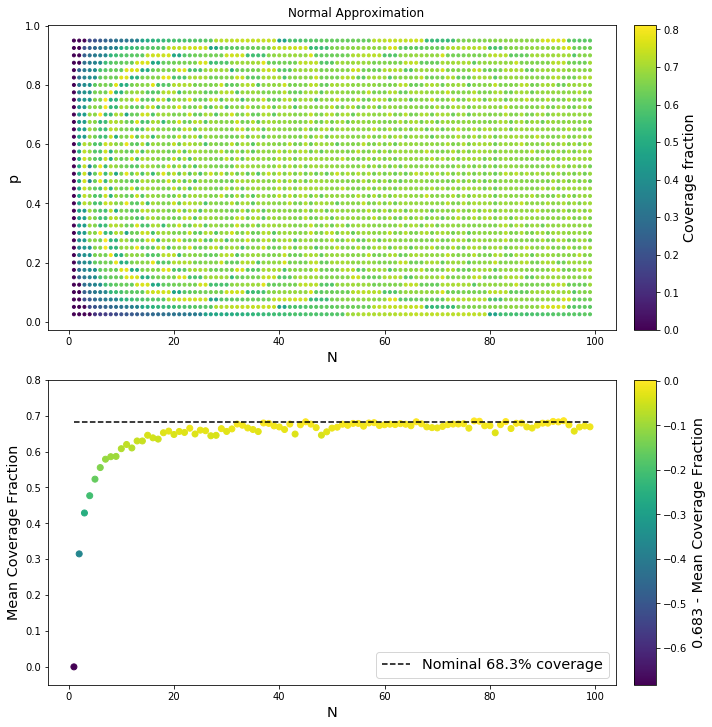

In [13]:
_ = plotCoverage(numTrialRange, 
                 trialCounts, 
                 successProbs, 
                 normalCoverageFractions,
                 nominalConfidence,
                 title='Normal Approximation')

This looks very much like th eplot for the _Normal Approximation_ case in [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf). So far so good! 
#### Part 4 B
Referring yet again to [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf) we're actually provided with a Python code snippet that computes the correct Binomial interval bounds!
```python
p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1) 
p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
```
As the paper states, and as we saw in the lectures, appropriate values for the interval bounds $p_{l}$ and $p_{u}$ are derived by normalizing the binomial likelihood function in the interval $[0,1]$ to yeild a _Beta_ distribution
\begin{equation}
B(a,b) = \frac{(a+b-1)!}{(a-1)!(b-1)!}\frac{p^{a-1}}{q^{b-1}}:\, a=k+1,\,b=n=k+1
\end{equation}
then solving to find $p_{l}$ and $p_{u}$ that satisfy
\begin{equation}
\int\limits_{0}^{p_{l}}B(a,b)dp = \alpha/2,\;\int\limits_{p_{u}}^{\infty}B(a,b)dp = \alpha/2
\end{equation}
where $\alpha$ is the confidence level specifying the fraction of the _Beta_ PDF that lies *outside* of the resultant confidence interval. These solutions are the _Percent-point Functions_ (or [Quantile functions](https://en.wikipedia.org/wiki/Quantile_function)) of the _Beta_ distribution, which is what the specified code snippet evaluates.

The `scipy.stats.distributions` functions operate on `numpy` arrays, but again, some transposition is required.

In [14]:
nominalConfidenceLevel = 1.0-nominalConfidence
binomialLowerBounds = spdists.beta.ppf(nominalConfidenceLevel/2.0,successCounts.T+1.0,(trialCounts - successCounts.T)+1.0)
binomialUpperBounds = spdists.beta.ppf(1.0-(nominalConfidenceLevel/2.0),successCounts.T+1.0,(trialCounts - successCounts.T)+1.0)

#### Part 5 B

In [15]:
binomialContainmentStatuses = ((binomialLowerBounds < successProbs) & (binomialUpperBounds > successProbs)).T
binomialCoverageFractions = np.sum(binomialContainmentStatuses, axis=1)/numVariates

#### Part 6 B

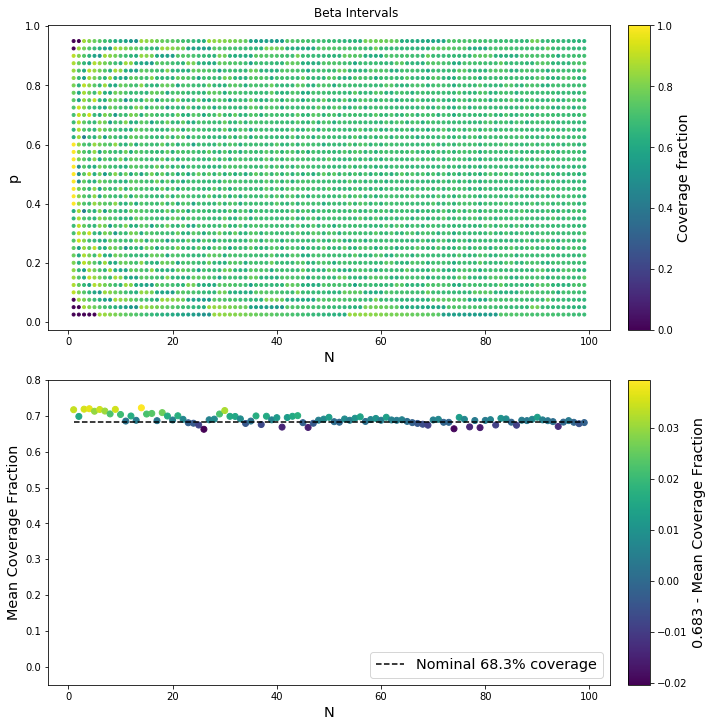

In [16]:
_ = plotCoverage(numTrialRange, 
                 trialCounts, 
                 successProbs, 
                 binomialCoverageFractions,
                 nominalConfidence, 
                 title='Beta Intervals')

### Exercise 2 (AST5031 Only):
Generalize the reasoning from _Exercise 1_ to a Poissonian distribution and repeat steps 1-6.

### Solution
#### Part 1
We can emulate the steps from _Excercise 1_. First, let's generate some Poisson distributed variates. Again, we can just use `numpy` routines. The poisson distribution has a single parameter that can be estimated. This parameter is called the _rate parameter_ and is denoted $\lambda$. Its probability mass function is defined as:
$$
f(k|\lambda)=\displaystyle {\frac {\lambda ^{k}e^{-\lambda }}{k!}}
$$
In fact, the Poisson distribution is a limiting case of the Binomial distribution when $N\rightarrow\infty$ and $p\rightarrow 0$ with the rate parameter defined to be $\lambda=Np$.

In [17]:
def poissonVariates(numTrials, successProb, numVariates):
    return nprandom.poisson(lam=numTrials * successProb, size=numVariates)

Again, we can generate and plot some variates to validate our code. Note that the distributions peak very close to the  true value of $\lambda$.

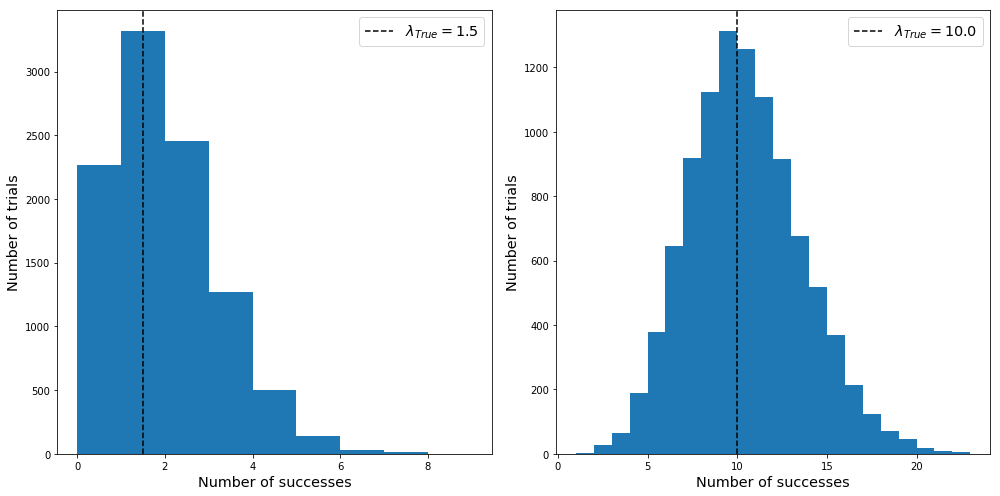

In [18]:
poissonTestFigure, poissonTestAxes = mplplot.subplots(ncols=2, nrows=1, figsize=(14,7))

numVariates=10000

for poissonTestAxis, numTrials, successProb in zip(poissonTestAxes, [30, 1000], [0.05, 0.01]):
    successCounts = poissonVariates(numTrials, successProb, numVariates)
    poissonTestAxis.hist(successCounts, 
                         bins=np.amax(successCounts) - np.amin(successCounts))
    
    poissonTestAxis.axvline(x=numTrials * successProb, ls='--', c='k',
                            label='$\lambda_{{True}}={}$'.format(numTrials * successProb))

    poissonTestAxis.set_xlabel('Number of successes', fontsize='x-large')
    poissonTestAxis.set_ylabel('Number of trials', fontsize='x-large')
    poissonTestAxis.legend(fontsize='x-large')

mplplot.tight_layout()

To compute our _approximate_ intervals and coverage, we need to compute an estimator for the rate parameter. We can use the [_Maximum Likelihood estimator_](https://en.wikipedia.org/wiki/Poisson_distribution#Maximum_likelihood) which is just the average of the observed values of $k$, aggregated over an ensemble of $n$ experiments.
$$
\hat{\lambda}={\widehat {\lambda }}_{\mathrm {MLE} }={\frac {1}{n}}\sum _{i=1}^{n}k_{i}
$$
Note that $n$ in the previous expression enumerates the number of **independent experiments** used to estimate $\lambda$. It is semantically distinct from $N = \lambda/p$ which is the number of trials comprising a **single experiment**.

For small true values of $\lambda$, only a handful of simulated experiments will yield $k > 0$. To obtain meaningful estimates for small $\lambda$, we need to simulate a large number of independent experiments and combine their results to compute $\hat{\lambda}$. This approach makes the mathematical expressions more complex so most subsequent discussion focusses on the confidence intervals for $\hat{\lambda}$ estimated for a **single** experiment. However, the simulation **code** incorporates a variable called `numExperimentsPerLambda` which is set to `1` by default. If you are interested, you can examine the code to discover how `numExperimentsPerLambda` is used to modify the computational expressions, and modify its value to determine how performing multiple experiments affects the sizes of the various confidence intervals.

If we want to estimate coverage fractions to at least 3 significant figures so we should compute at least $10^{4}$ $\hat{\lambda}$ values (with accompanying confidence intervals) for each true value of $\lambda$. 

Now we can write a function that simulates experiments to estimate $\lambda$ for different combinationsof $N$ and $p$. So that we don't have to store huge arrays of numbers we'll compute our $\hat{\lambda}$ estimates on the fly. 

In [19]:
def poissonProcesses(numTrialRange, successProbRange, numExperimentsPerLambda = 1, numVariatesPerExperiment = int(1e4)):
    return collections.OrderedDict(
        {
            (numTrials, successProb): 
                np.average(
                    np.reshape(poissonVariates(numTrials, 
                                               successProb, 
                                               numVariatesPerExperiment*numExperimentsPerLambda),
                               (numVariatesPerExperiment, 
                               numExperimentsPerLambda)
                              ),
                    axis=1
                ) for successProb in successProbRange for numTrials in numTrialRange
        }
    )

In [20]:
## Define sensible ranges for the numbers of trials (N) and success probabilities (p)
numTrialRange = np.linspace(1000, 10000, 25).astype(int)
successProbRange = np.logspace(-6, -2, 25)

## Convert these into values of lambda = Np and check the range of resultant values
permutations = np.outer(numTrialRange, successProbRange)
lambdaValues = np.unique(np.sort(permutations))
print('Maximum and minimum lambda values are {} and {}, respectively'.format(
    np.amax(lambdaValues), 
    np.amin(lambdaValues)
))

Maximum and minimum lambda values are 100.0 and 0.001, respectively


In [21]:
numVariatesPerExperiment = int(1e4)
numExperimentsPerLambda = 1000
poissonExperiments = poissonProcesses(numTrialRange, successProbRange, 
                                      numExperimentsPerLambda=numExperimentsPerLambda, 
                                      numVariatesPerExperiment=numVariatesPerExperiment)

In [22]:
trialCounts, successProbs = np.array(list(poissonExperiments.keys())).T
meanSuccessCounts = np.array(list(poissonExperiments.values()))

#### Approximate Intervals
There are several [commonly used approximation formulae](https://www-cdf.fnal.gov/physics/statistics/notes/cdf6438_coverage.pdf) for _Poisson_ intervals. A close analogue of the _Normal Approximation_ that is [often used](https://www-cdf.fnal.gov/physics/statistics/notes/pois_eb.txt) to estimate the errors on $\hat{\lambda}$ and implies $1\sigma$ confidence intervals defined as 
$$
\hat{\lambda} - \sqrt{\hat{\lambda}} \leq \lambda \leq \hat{\lambda} + \sqrt{\hat{\lambda}}.
$$
A slightly more complicated definition is suggested by the [Common Data Format Statistics Committee](https://www-cdf.fnal.gov/physics/statistics/notes/pois_eb.txt).
$$
\hat{\lambda}+0.5-\sqrt{\hat{\lambda}+0.25} \leq \lambda \leq \hat{\lambda}+0.5+\sqrt{\hat{\lambda}+0.25}
$$
Quoting from their discussion:
> Some of the advantages of this algorithm are that it gives non-zero
error bars for n=0; it produces an error bar that does not go all the
way down to zero when n=1; and it yields asymmetric error bars that
reflect the asymmetry of the Poisson distribution.

We'll investigate the coverage using both formulae, starting with the **simpler one**!

In [23]:
trueVals = (trialCounts*successProbs).T
lambdaEstimators = meanSuccessCounts

poissonNormalDeviations = np.sqrt(lambdaEstimators/numExperimentsPerLambda)
poissonNormalLowerBounds = (lambdaEstimators) - poissonNormalDeviations
poissonNormalUpperBounds = (lambdaEstimators) + poissonNormalDeviations

poissonNormalContainmentStatuses = (
    (
        poissonNormalLowerBounds.T < trialCounts*successProbs
    ) & (
        poissonNormalUpperBounds.T > trialCounts*successProbs
    )
).T

poissonNormalCoverageFractions = np.sum(poissonNormalContainmentStatuses, axis=1)/poissonNormalContainmentStatuses.shape[1]

Let's define another plotting function that's better tailored for plotting the coverage of _Poisson_ intervals.

In [24]:
def plotCoveragePoisson(numTrialRange, trialCounts, successProbs, coverageFractions, nominalCoverageFraction, title):
    ## Define a figure with two rows of two columns. Each row contains a wide panel for the plot and 
    ## narrow panel for a corresponding colour bar.
    coverageFigure, coverageAxes = mplplot.subplots(ncols=2, 
                                                    nrows=2,
                                                    figsize=(10, 10), 
                                                    gridspec_kw=dict(width_ratios=[25,1])
                                                   )
    ## Top-left panel
    coverage2dAxes = coverageAxes[0][0]
    ## 2D plot of coverage fraction versus N, p
    coverage2dPlot = coverage2dAxes.scatter(trialCounts, successProbs, c=coverageFractions, marker='.', s=200)
    ## Add colour bar in top-right panel
    coverage2dColourbar = mplplot.colorbar(coverage2dPlot, cax = coverageAxes[0][1])
    coverage2dAxes.set_xlabel('N', fontsize = 'x-large')
    coverage2dAxes.set_ylabel('p', fontsize = 'x-large')
    coverage2dColourbar.set_label('Coverage fraction', fontsize = 'x-large')

    ## Bottom-left panel
    coverage1dAxes = coverageAxes[1][0]
    ## 1D plot of coverage fraction versus lambda
    coverage1dPlot = coverage1dAxes.scatter(trialCounts*successProbs, coverageFractions, c=coverageFractions - nominalCoverageFraction)
    ## Add colour bar in bottom-right panel
    coverage1dColourbar = mplplot.colorbar(coverage1dPlot, cax = coverageAxes[1][1])
    coverage1dAxes.plot(trialCounts*successProbs, nominalCoverageFraction*np.ones_like(trialCounts*successProbs), c='k', ls='--', label='Nominal {:.1f}% coverage'.format(100*nominalCoverageFraction))
    coverage1dAxes.legend(fontsize = 'x-large', loc='lower right')
    coverage1dAxes.set_ylim(-0.05, 0.8)
    coverage1dAxes.set_xlabel('$\lambda$', fontsize = 'x-large')
    coverage1dAxes.set_ylabel('Coverage Fraction', fontsize = 'x-large')
    coverage1dColourbar.set_label('{:.3f} - Coverage Fraction'.format(nominalCoverageFraction), fontsize = 'x-large')
    
    coverageFigure.suptitle(title, y=1.005)
    
    mplplot.tight_layout()
    ## Return figure and axes to enable overplotting and augmentation if required
    return coverageFigure, coverageAxes

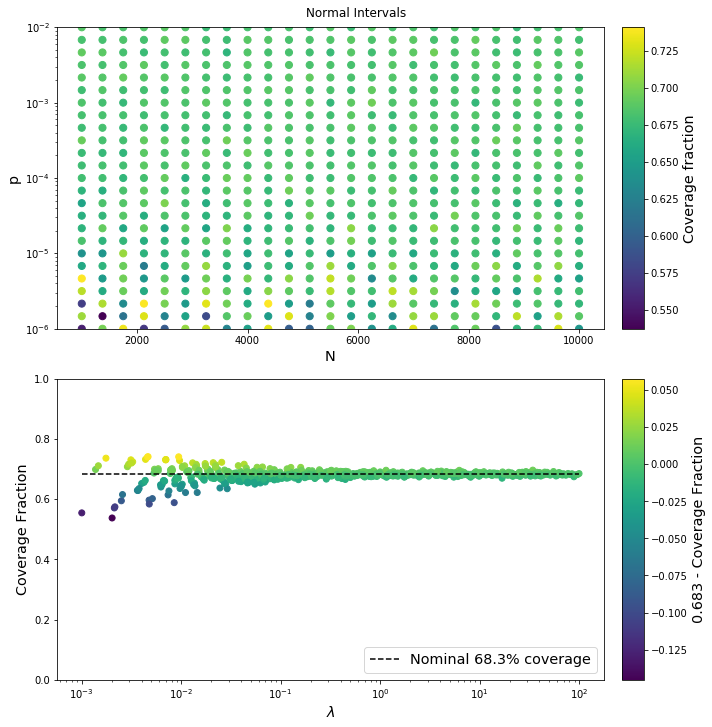

In [25]:
normalPoissonFigure, normalPoissonAxes = plotCoveragePoisson(numTrialRange,
                                                             trialCounts,
                                                             successProbs, 
                                                             poissonNormalCoverageFractions,
                                                             nominalConfidence, 
                                                             title='Normal Intervals')

normalPoissonAxes[0][0].set_yscale('log')
normalPoissonAxes[0][0].set_ylim(successProbRange[0], successProbRange[-1])

normalPoissonAxes[1][0].set_ylim(0, 1.0)
normalPoissonAxes[1][0].set_xscale('log')


mplplot.tight_layout()

Now let's try with the **slightly more complicated** expression.

In [26]:
poissonPearsonDeviations = np.sqrt(lambdaEstimators*numExperimentsPerLambda + 0.25)
poissonPearsonLowerBounds = lambdaEstimators*numExperimentsPerLambda + 0.5 - poissonPearsonDeviations
poissonPearsonUpperBounds = lambdaEstimators*numExperimentsPerLambda + 0.5 + poissonPearsonDeviations

poissonPearsonContainmentStatuses = (
    (
        poissonPearsonLowerBounds.T/numExperimentsPerLambda < trialCounts*successProbs
    ) & (
        poissonPearsonUpperBounds.T/numExperimentsPerLambda > trialCounts*successProbs
    )
).T

poissonPearsonCoverageFractions = np.sum(poissonPearsonContainmentStatuses, axis=1)/poissonPearsonContainmentStatuses.shape[1]

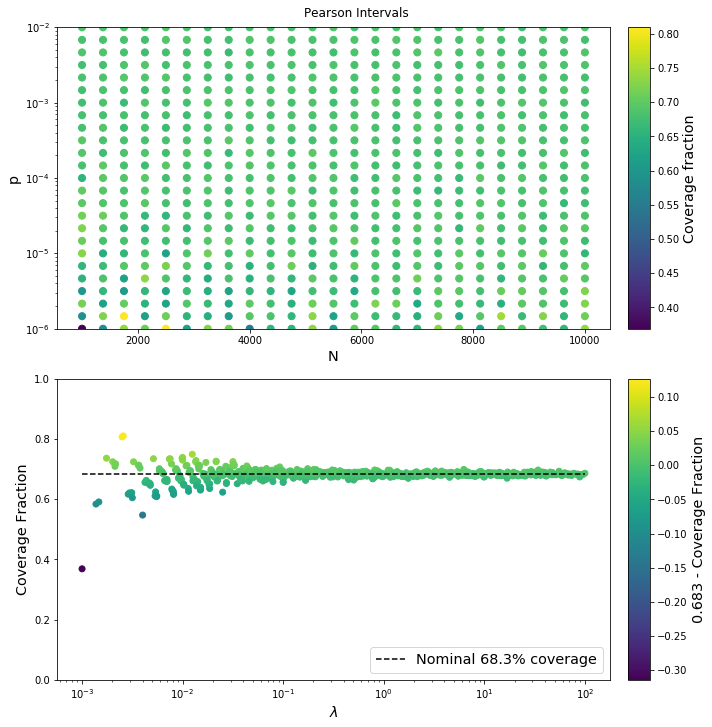

In [27]:
poissonPearsonFigure, poissonPearsonAxes = plotCoveragePoisson(numTrialRange,
                                                               trialCounts,
                                                               successProbs, 
                                                               poissonPearsonCoverageFractions,
                                                               nominalConfidence, 
                                                               title='Pearson Intervals')

poissonPearsonAxes[0][0].set_yscale('log')
poissonPearsonAxes[0][0].set_ylim(successProbRange[0], successProbRange[-1])

poissonPearsonAxes[1][0].set_xscale('log')
poissonPearsonAxes[1][0].set_ylim(0, 1.0)

mplplot.tight_layout()

#### Bayesian Intervals
[The _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf) derives definitions for Bayesian _credible interval_ bounds for the _Binomial_ success probability, $p$ using sampled data. We need to use the same reasoning to derive similar bounds for the _Poisson_ rate parameter, $\lambda$.

For a set $\{k_{i}\}:\,i=1\ldots n$ of samples from a _Poisson_ distribution the likelihood is simple the product of the liklihoods for each sample.
\begin{equation}
P(\{k_{i}\}|\lambda) = \displaystyle\prod\limits_{i=1}^{n}\frac{\lambda^{k_{i}}e^{\lambda}}{k_{i}!} = \frac{\lambda^{\sum_{i}k_{i}}\cdot e^{n\lambda}}{\prod\limits_{i=1}^{n}(k_{i}!)}\propto \lambda^{\sum_{i}k_{i}}\cdot e^{n\lambda}
\end{equation}
Emulating [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf) and assuming a uniform prior on $\lambda$ such that $P(\lambda)\propto 1$, and applying Bayes's rule we obtain an expression for the posterior probability
$$
P(\lambda|\{k_{i}\})\propto P(\{k_{i}\}|\lambda)\cdot P(\lambda) \propto \lambda^{\sum_{i}k_{i}}\cdot e^{n\lambda} = \lambda^{(\sum_{i}k_{i})+1 - 1}\cdot e^{n\lambda}
$$
The final equality is a trivial algebraic manipulation which shows that the posterior is proportional to the kernel (i.e. the non-normalized functional dependency) of the [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution) which has the general formula
$$
\mathrm{Gamma}(x|\alpha, \beta) = \displaystyle {\frac {\beta ^{\alpha }}{\Gamma (\alpha )}}x^{\alpha -1}e^{-\beta x}
$$
where $\Gamma(x)$ is the [gamma **function**](https://en.wikipedia.org/wiki/Gamma_function). The fundamental point is that since $P(\lambda|\{k_{i}\})\propto \mathrm{Gamma}(\lambda|(\sum_{i}k_{i})+1, n)$, and we require that $P(\lambda|\{k_{i}\})$ be a **normalized** probability distribution, it is valid to write
$$
P(\lambda|\{k_{i}\})= \mathrm{Gamma}(\lambda|(\sum_{i}k_{i})+1, n)
$$
While we could try to compute the _percent-point function_ of the Gamma distribution do derive our credible interval, it is more common in the literature to use the [fact](https://en.wikipedia.org/wiki/Gamma_distribution#Related_distributions_and_properties) that if a random variable $X\sim \mathrm{Gamma}(\alpha/2, \beta)$, then $X$ also obeys a $\chi^{2}$ distribution with $alpha$ degrees of freedom.
$$
X\sim \mathrm{Gamma}(\alpha/2, \beta)\implies X\sim \chi^{2}(\alpha)
$$
It is more common to use the _percent-point function_ of the $\chi^{2}$ distribution to compute the bounds of our credible interval. The required bounds can be found using anologues of _Equation 3_ in the [the _Essential Reading_](https://arxiv.org/pdf/1012.0566.pdf). They are the values of $p_{l}$ and $p_{u}$ that satisfy
\begin{equation}
\int\limits_{0}^{p_{l}}\chi^{2}(2\lambda)dp = \alpha/2,\:\int\limits_{p_{u}}^{\infty}\chi^{2}(2\lambda)dp = \alpha/2
\end{equation}
The `scipy.stats.distributions.chi2.ppf` function is used in the subsequent cell to compute $p_{l}$ and $p_{u}$.

In [28]:
bayesianLowerBounds = (0.5/numExperimentsPerLambda)*spdists.chi2.ppf(0.5*nominalConfidenceLevel,2.0*lambdaEstimators*numExperimentsPerLambda+2.0)
bayesianUpperBounds = (0.5/numExperimentsPerLambda)*spdists.chi2.ppf((1.0-0.5*nominalConfidenceLevel),2.0*lambdaEstimators*numExperimentsPerLambda+2.0)

Finally, we can compute the containment fractions for our _Bayesian Intervals_ and plot the resultant coverage statistics.

In [29]:
bayesianContainmentStatuses = ((bayesianLowerBounds.T < trialCounts*successProbs) & (bayesianUpperBounds.T > trialCounts*successProbs)).T
bayesianCoverageFractions = np.sum(bayesianContainmentStatuses, axis=1)/bayesianContainmentStatuses.shape[1]

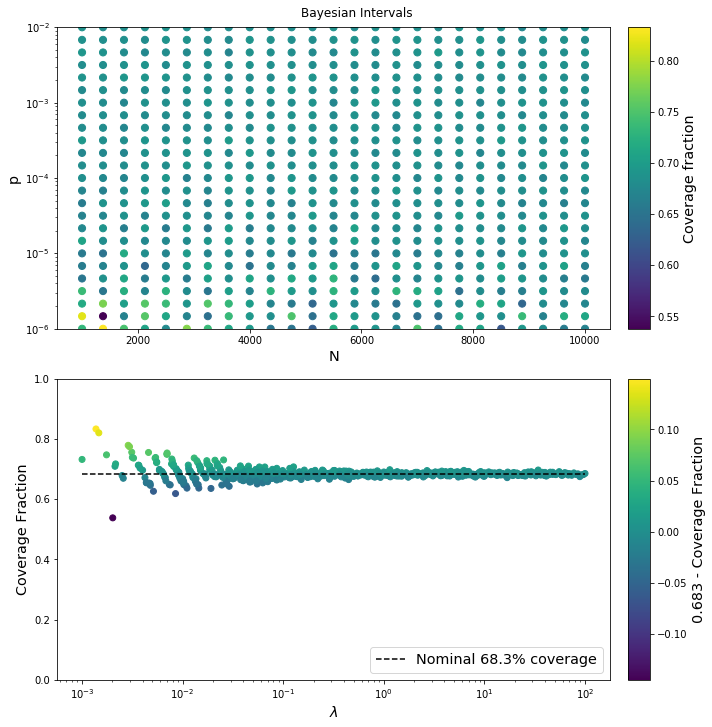

In [30]:
bayesianPoissonFigure, bayesianPoissonAxes = plotCoveragePoisson(numTrialRange, 
                                                                 trialCounts,
                                                                 successProbs, 
                                                                 bayesianCoverageFractions,
                                                                 nominalConfidence, 
                                                                 title='Bayesian Intervals')

bayesianPoissonAxes[0][0].set_yscale('log')
bayesianPoissonAxes[0][0].set_ylim(successProbRange[0], successProbRange[-1])

bayesianPoissonAxes[1][0].set_xscale('log')
bayesianPoissonAxes[1][0].set_ylim(0, 1)

mplplot.tight_layout()